# ESTIMATE AVG DISTANCE, STOP QUANITY EACH BUS ROUTE
### Tính số m di chuyển trung bình và số trạm đi quan trung bình cho mỗi tuyến bus

In [1]:
import yaml
import pandas as pd
import numpy as np
from lxml import etree
import seaborn as sns
import matplotlib.pyplot as plt

import shutil
import os
import csv

# 0. Set up các file

#### Simple test

In [2]:
# SCHEDULE_PATH = "data\\simple_scenario\\schedule.xml"
# NETWORK_PATH = "data\\simple_scenario\\network.xml"
# NAME_SCENARIO = "SIMPLE IMPROVEMENT"  # Change this value accordingly



### After Scenario

In [3]:
# SCHEDULE_PATH = "data\\after\\output_transitSchedule.xml"
# NETWORK_PATH = "data\\after\\network.xml"

# NAME_SCENARIO = "AFTER IMPROVEMENT"  # Change this value accordingly

# OUTPUT_IMAGE_PATH = "data\\after\\scoring\\distance_and_map_bus_route\\bus_network_map.png"
# OUTPUT_FOLDER = "data\\after\\scoring\\distance_and_map_bus_route"

### Before Scenario 

In [4]:
SCHEDULE_PATH = "data\\before\\output_transitSchedule.xml"
NETWORK_PATH = "data\\before\\network.xml"

NAME_SCENARIO = "BEFORE IMPROVEMENT"  # Change this value accordingly

OUTPUT_IMAGE_PATH = "data\\before\\scoring\\distance_and_map_bus_route\\bus_network_map.png"
OUTPUT_FOLDER = "data\\before\\scoring\\distance_and_map_bus_route"

### Real Scenario

In [5]:
# TRANSIT_VEHICLE_SCHEDULE_PATHPATH = "data\\real\\transit_schedule.xml"
# NETWORK_PATH = "data\\real\\network.xml"
# OUTPUT_DATA_FOLDER = "data\\real\\scoring\\distance_and_map_bus_route\\bus_network_map.png"

# OUTPUT_IMAGE_PATH = "data\\real\\scoring\\distance_and_map_bus_route"
# OUTPUT_FOLDER = "data\\real\\scoring\\distance_and_map_bus_route"


In [6]:
if os.path.exists(OUTPUT_FOLDER):
    shutil.rmtree(OUTPUT_FOLDER)

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

## 1. Đọc file schedule lấy thông tin từng route bus

In [7]:
!powershell -Command "Get-Content 'data\simple_scenario\schedule.xml' -TotalCount 100 | ForEach-Object { '{0:5}: {1}' -f $_.ReadCount, $_ }"

5: <?xml version="1.0" encoding="UTF-8"?>
5: <!DOCTYPE transitSchedule SYSTEM "http://www.matsim.org/files/dtd/transitSchedule_v1.dtd">
5: <transitSchedule>
5:  <transitStops>
5:   <stopFacility id="stop_1" x="463000.0" y="5740000.0" linkRefId="1"/>
5:   <stopFacility id="stop_5" x="466000.0" y="5740000.0" linkRefId="5"/>
5:   <stopFacility id="stop_9" x="469000.0" y="5740000.0" linkRefId="9"/>
5:   <stopFacility id="stop_13" x="472000.0" y="5740000.0" linkRefId="13"/>
5:   <stopFacility id="stop_17" x="475000.0" y="5740000.0" linkRefId="17"/>
5:   <stopFacility id="stop_18" x="472000.0" y="5740000.0" linkRefId="18"/>
5:   <stopFacility id="stop_14" x="469000.0" y="5740000.0" linkRefId="14"/>
5:   <stopFacility id="stop_10" x="466000.0" y="5740000.0" linkRefId="10"/>
5:   <stopFacility id="stop_6" x="463000.0" y="5740000.0" linkRefId="6"/>
5:   <stopFacility id="stop_2" x="460000.0" y="5740000.0" linkRefId="2"/>
5:   <stopFacility id="stop_45" x="463000.0" y="5746000.0" linkRefId="45"/

### Tạo class chứa thông tin từng bus route

In [8]:
class RouteData:
    def __init__(self, id: str, linkId_list: list[str], stop_number: int):
        self.id = id
        self.linkId_list = linkId_list
        self.stop_number = stop_number
        self.travel_distance = 0

### Lưu route data

In [9]:
hint_bus_route = ["pt", "bus"]
bus_route_data: list[RouteData] = []

parser = etree.XMLParser(remove_blank_text=True)
tree = etree.parse(SCHEDULE_PATH, parser)
root = tree.getroot()


for node in root.xpath("//transitSchedule/transitLine/transitRoute"):
    for hint in hint_bus_route:

        if node.xpath("./transportMode/text()")[0] == hint:
            id = node.xpath("@id")[0]
            stops: list = node.xpath("./routeProfile/stop/@refId")

            links: list = node.xpath("./route/link/@refId")
            bus_route_data.append(RouteData(id, links, len(stops)))
            print([[id,links,stops]])
            continue


[['10_out', ['3503', '9962', '9982', '9983', '9984', '10517', '10617', '2583', '7935', '8952', '6066', '5892', '2498', '6666', '2390', '6599', '6597', '6645', '6782', '6780', '6778', '6776', '2513', '2515', '9762', '9760', '9758', '9756', '314', '5376', '2097', '2099', '5971', '5969', '5967', '8395', '2093', '874', '876', '81', '83', '1868', '4825'], ['9470168_a', '9470294_b', '9470269_c', '9470155_a', '9470232_a', '9470159_a', '9470290_a', '9470118_a', '9470150_a', '9470264_a', '9470127_a']]]
[['10_in', ['4825', '4824', '1869', '84', '82', '877', '875', '2095', '2435', '2437', '9750', '9754', '9752', '6822', '6820', '6818', '6816', '2448', '2446', '2444', '3302', '4003', '4005', '4007', '5182', '3009', '5184', '2097', '2099', '2100', '2098', '5377', '313', '9755', '9757', '9759', '9761', '2514', '2512', '6775', '6777', '6779', '6781', '6644', '6596', '6598', '2389', '6667', '2501', '5634', '6067', '6662', '2169', '8505', '8503', '10103', '4980', '5131', '2582', '10616', '10516', '9994

# 2 Đọc network data lấy độ dài cạnh

In [10]:
class Node:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y

class Link:
    def __init__(self, id: str, from_node: str, to_node: str):
        self.id = id
        self.from_node = from_node
        self.to_node = to_node

In [11]:
!powershell -Command "Get-Content 'data\\simple_scenario\\network.xml' -TotalCount 110 | ForEach-Object { '{0:5}: {1}' -f $_.ReadCount, $_ }"

5: <?xml version="1.0" encoding="UTF-8"?>
5: <!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v1.dtd">
5: <network>
5:   <nodes>
5:     <node id="n_0_0" x="460000.0" y="5740000.0" />
5:     <node id="n_1_0" x="463000.0" y="5740000.0" />
5:     <node id="n_2_0" x="466000.0" y="5740000.0" />
5:     <node id="n_3_0" x="469000.0" y="5740000.0" />
5:     <node id="n_4_0" x="472000.0" y="5740000.0" />
5:     <node id="n_5_0" x="475000.0" y="5740000.0" />
5:     <node id="n_0_1" x="460000.0" y="5743000.0" />
5:     <node id="n_1_1" x="463000.0" y="5743000.0" />
5:     <node id="n_2_1" x="466000.0" y="5743000.0" />
5:     <node id="n_3_1" x="469000.0" y="5743000.0" />
5:     <node id="n_4_1" x="472000.0" y="5743000.0" />
5:     <node id="n_5_1" x="475000.0" y="5743000.0" />
5:     <node id="n_0_2" x="460000.0" y="5746000.0" />
5:     <node id="n_1_2" x="463000.0" y="5746000.0" />
5:     <node id="n_2_2" x="466000.0" y="5746000.0" />
5:     <node id="n_3_2" x="469000.0" y="5746

### map linkid với độ dài link

In [12]:
link_length_mapping: dict[str, float] = {}

tree = etree.parse(NETWORK_PATH, parser)
root = tree.getroot()

for node in root.xpath("//network/links/link"):
    link_id = node.xpath("@id")[0]
    length = node.xpath("@length")[0]
    link_length_mapping[link_id] = float(length)

### Taoj list node va link tu file network.xml

In [13]:
link_list: list[Link] = []
node_list: list[Node] = []

for node in root.xpath("//network/links/link"):
    link_id = node.xpath("@from")[0]
    length = node.xpath("@to")[0]
    link_list.append(Link(link_id, node.xpath("@from")[0], node.xpath("@to")[0]))
    
    print(link_id, length)
    
for node in root.xpath("//network/nodes/node"):
    node_id = node.xpath("@id")[0]
    x = node.xpath("@x")[0]
    y = node.xpath("@y")[0]
    node_list.append(Node(node_id, x, y))
    
    print (node_id, x, y)


31559588 31559589
448010227 121904163
32671488 33336549
700999195 32945199
35880380 35880401
33099870 32945613
32945613 33099870
35880401 35880375
35880375 35880401
35880375 35880373
35880373 35880375
32945613 32945619
32945619 32945613
32945619 32945353
32945199 700999195
32945353 32945619
30236038_30236053_30236052_30236042 98743278
98743278 27192292
35880384 35880393
35880393 35880384
35880383 35880393
35880393 35880383
35880393 35880395
35880395 35880393
487388912 31041501
32945667 32944778
31041501 487388912
35881300 35880430
35880430 35881300
35880325 60662810
60662810 35880325
32945353 32945354
32945354 32945353
32945354 32945366
32945366 32945354
32945366 32945369
32944778 32945667
32945369 32945366
32945369 32945376
32945376 32945369
32945376 32945380
32945380 32945376
32945380 32945389
32945389 32945380
32945389 32945410
32945410 32945389
31074236 808433764
32944778 700999179
808433764 31074236
808433764 31074248
31074248 808433764
31074248 808433767
808433767 31074248
808433

# 3 Thêm độ dài cho các route

In [14]:
for route in bus_route_data:
    distance: float = 0
    for link in route.linkId_list:
        distance += link_length_mapping[link]

    route.distance = distance        
    print([route.id, route.distance])

['10_out', 5244.47175099779]
['10_in', 11167.902277963885]
['12_out', 11482.401635183074]
['12_in', 13330.693063628056]
['13_out', 3267.511332293255]
['13_in', 3456.9516241601723]
['1417_out', 16677.790798417533]
['1417_in', 20187.230221744187]
['15_out', 9313.93479207843]
['15_in', 9854.888634371655]
['16_out', 15083.763064403964]
['16_in', 16031.921830006353]
['19_out', 16624.313231846416]
['19_in', 16597.237074766716]
['20_out', 5859.425170492375]
['20_in', 5812.412341075556]
['21_out', 8670.500013265228]
['21_in', 8805.724993300673]


# 4 Tính toán số bến trung bình và số m đi trung bình của từng tuyến xe bus


In [15]:
avg_stop_number = np.mean([route.stop_number for route in bus_route_data])
avg_distance_number = np.mean([route.distance for route in bus_route_data])
print(f" {NAME_SCENARIO} So tram dung trung binh cua 1 tuyen: {avg_stop_number}")
print(f" {NAME_SCENARIO} So km di trung binh cua 1 tuyen: {avg_distance_number/1000}")


 BEFORE IMPROVEMENT So tram dung trung binh cua 1 tuyen: 18.055555555555557
 BEFORE IMPROVEMENT So km di trung binh cua 1 tuyen: 10.970504102777518


Starting Visualization V4 (Full Network Base Layer)...

Parsing network data from data\before\network.xml...
Loaded 10729 links from network.
Processing Base Network Layout...
Processing 912 Bus Segments...
Generating plot...
Focused on active area: [447852.0371646221, 459957.33159681957] x [5727989.284768257, 5741818.504468739]
Saved to data\before\scoring\distance_and_map_bus_route\bus_network_map.png


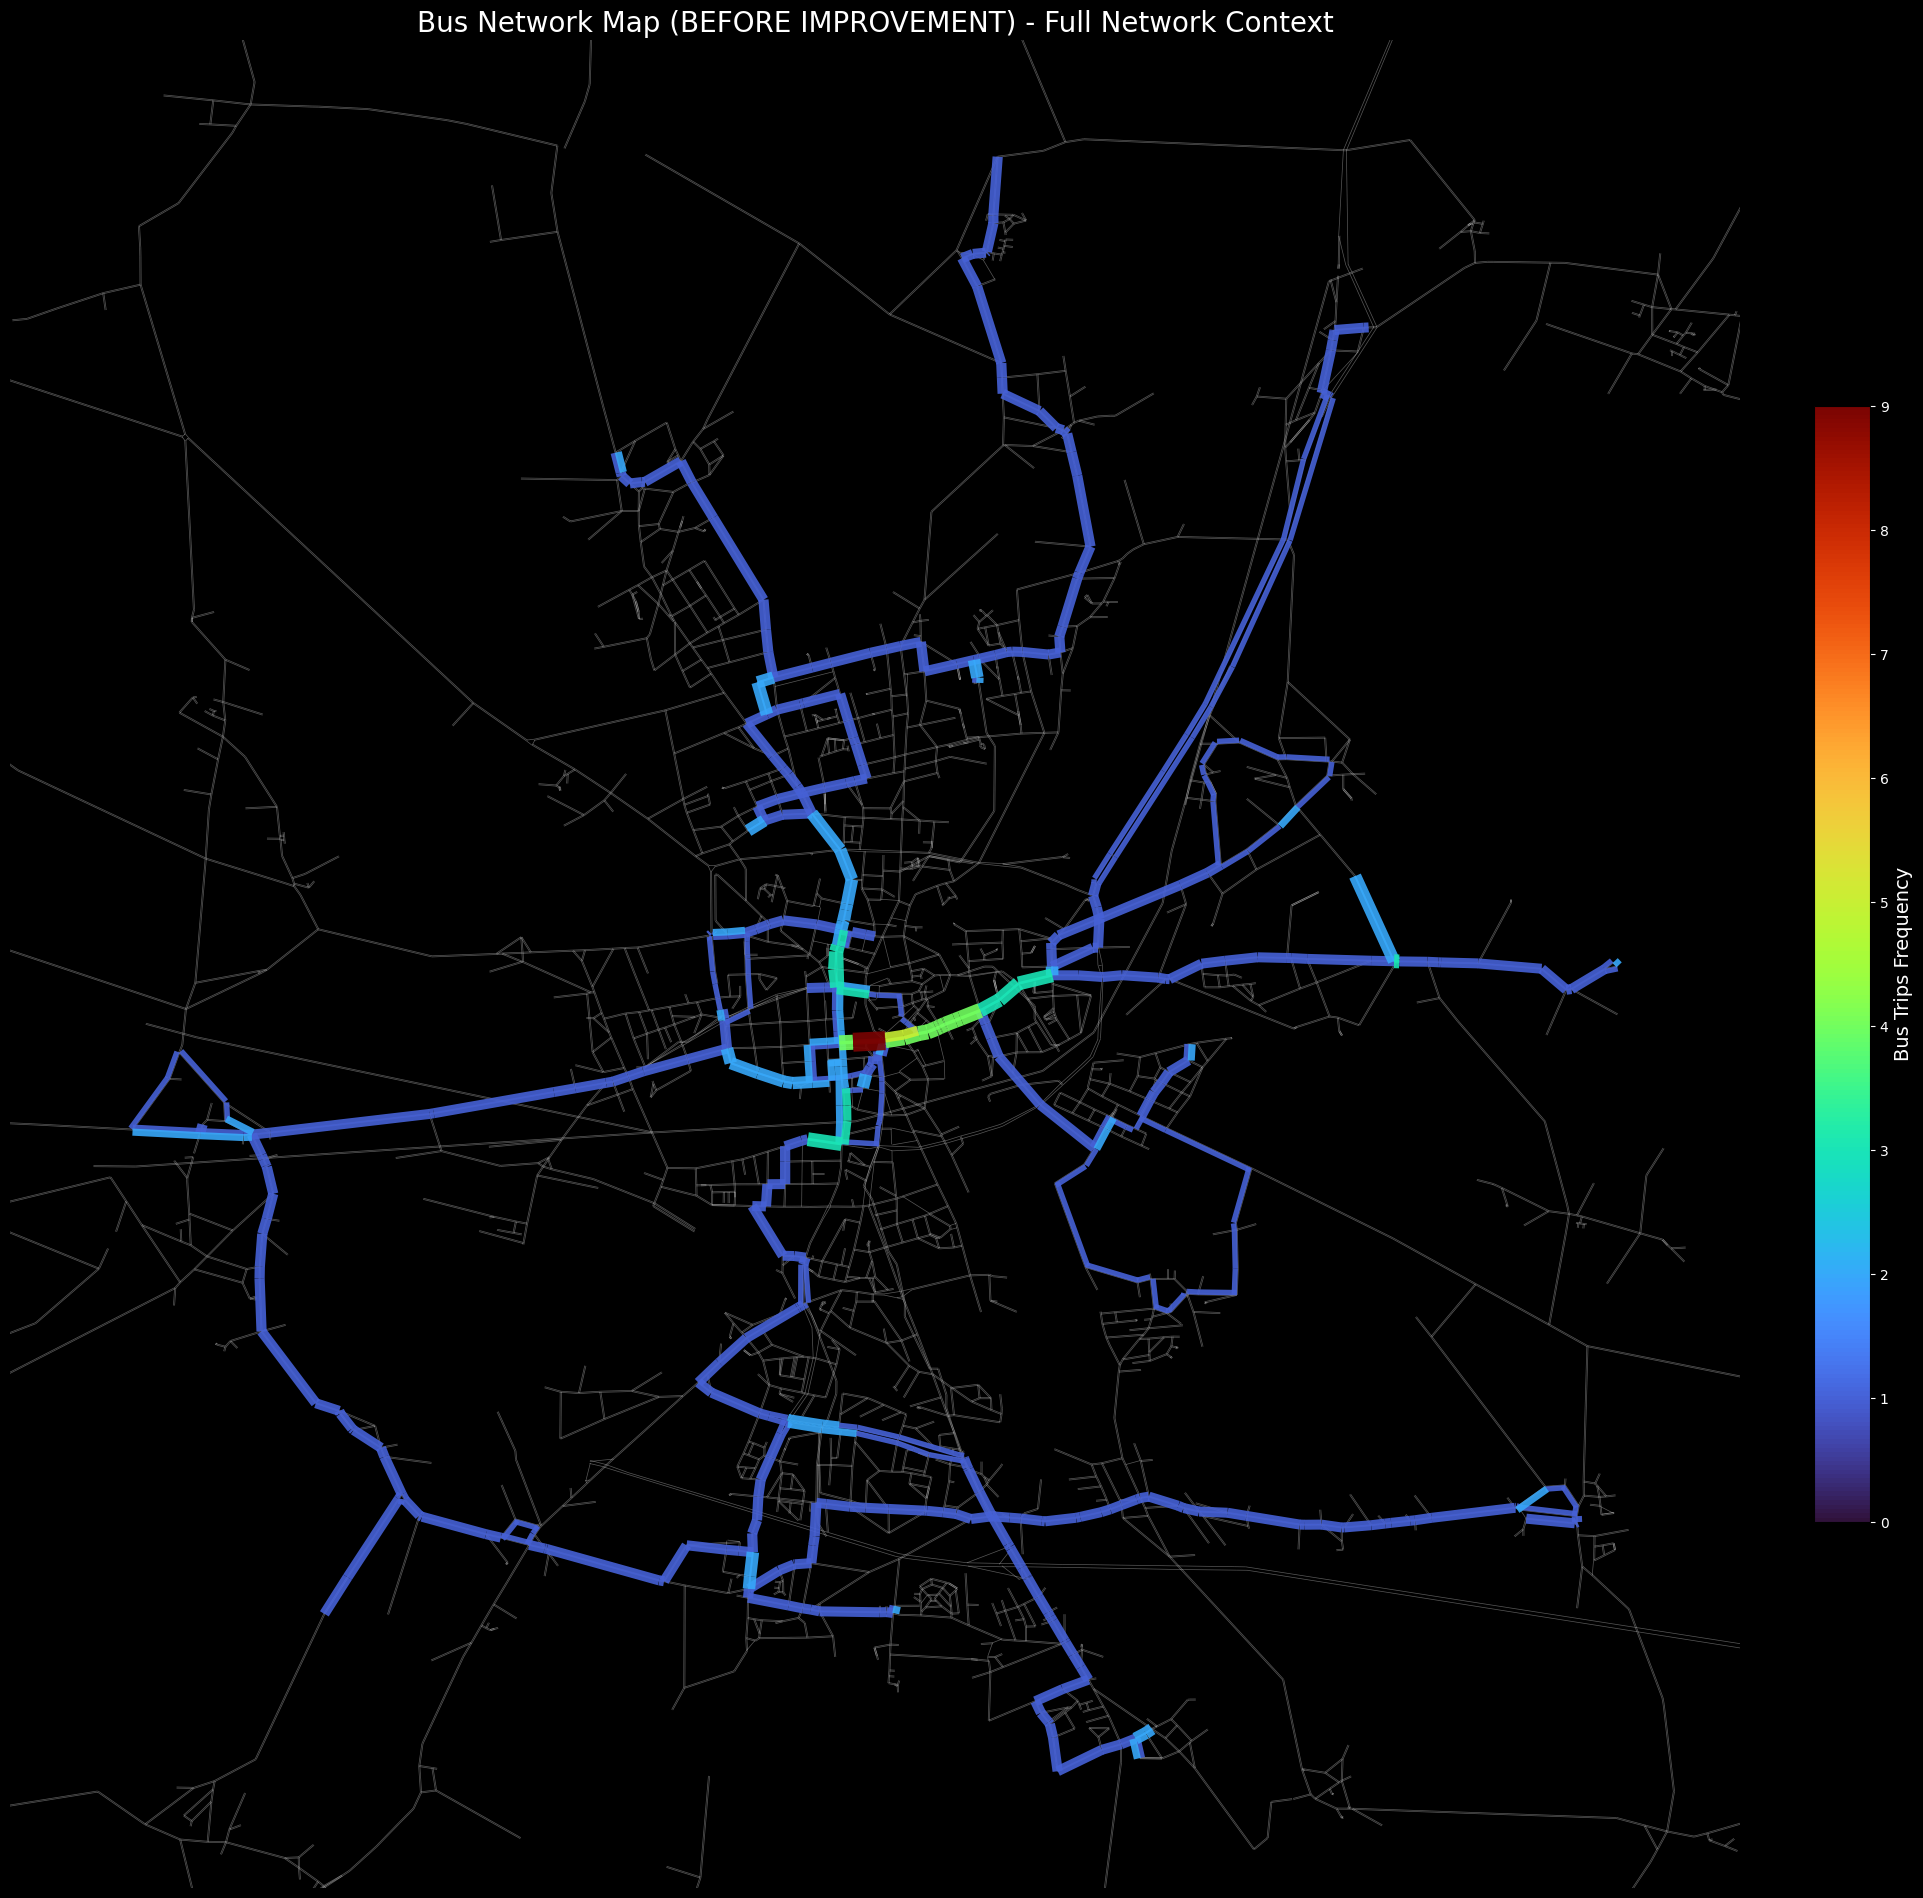

In [16]:
# === VISUALIZATION BLOCK GENERATED BY AI ===
# This block focuses on visualizing the bus network with directional offsets and frequency-based width/color.
# Layer Order: Black Background -> Gray Base Network (All Links) -> Bus Network (Colored/Widened)

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from matplotlib import cm
from lxml import etree
import os
import numpy as np
from collections import Counter

def get_offset_coords(p1, p2, offset):
    """Shift line p1-p2 to the right by offset amount"""
    x1, y1 = p1
    x2, y2 = p2
    dx = x2 - x1
    dy = y2 - y1
    length = np.sqrt(dx*dx + dy*dy)
    if length == 0:
        return p1, p2
    
    # Normalized perpendicular vector (right hand side)
    nx = dy / length
    ny = -dx / length
    
    # Apply offset
    ox = nx * offset
    oy = ny * offset
    
    return [(x1 + ox, y1 + oy), (x2 + ox, y2 + oy)]

def map_bus_network_advanced(output_image_path: str):
    print("Starting Visualization V4 (Full Network Base Layer)...\n")
    
    # 1. Parse Network Geometry
    if 'NETWORK_PATH' not in globals():
        print("Error: NETWORK_PATH variable not found.")
        return
    
    try:
        print(f"Parsing network data from {NETWORK_PATH}...")
        network_tree = etree.parse(NETWORK_PATH)
        network_root = network_tree.getroot()
        
        nodes_xy = {}
        for node in network_root.xpath("//network/nodes/node"):
            nodes_xy[node.get('id')] = (float(node.get('x')), float(node.get('y')))
            
        all_links_geom = {}
        for link in network_root.xpath("//network/links/link"):
            lid = link.get('id')
            fid = link.get('from')
            tid = link.get('to')
            if fid in nodes_xy and tid in nodes_xy:
                all_links_geom[lid] = [nodes_xy[fid], nodes_xy[tid]]
        print(f"Loaded {len(all_links_geom)} links from network.")
    except Exception as e:
        print(f"Failed to parse network xml: {e}")
        return

    # 2. Count Bus Link Frequency
    bus_link_counts = Counter()
    if 'bus_route_data' in globals():
        for route in bus_route_data:
            link_list = []
            if hasattr(route, 'linkId_list'):
                link_list = route.linkId_list
            elif hasattr(route, 'links'):
                link_list = route.links
            elif hasattr(route, 'link_ids'):
                link_list = route.link_ids
            bus_link_counts.update(link_list)
    
    # 3. Prepare Plot Layers
    base_lines = []
    bus_lines = []
    bus_widths = []
    bus_colors = []
    
    focus_x = []
    focus_y = []
    
    # -- Configuration --
    # Offset scaling
    offset_base_meters = 12.0 # Minimum separation for base traffic
    # Bus width logic
    def get_width(freq):
        return 1.8 + (np.log(freq + 1) * 3) # Width scaling
    
    offset_multiplier = 2.0 
    cmap = plt.get_cmap('turbo')
    max_freq = max(bus_link_counts.values()) if bus_link_counts else 1
    norm = plt.Normalize(0, max_freq)

    # 3a. Process Base Links (ALL LINKS)
    # User request: "vẽ các link của cả bản đồ mạng lưới... ở giữu background với lớp vẽ bus"
    print("Processing Base Network Layout...")
    for lid, coords in all_links_geom.items():
        p1, p2 = coords
        # Apply small offset to base links too so bidirectional roads don't look like one line
        # and to ensure they sit 'under' the bus lanes correctly if aligned
        p_new = get_offset_coords(p1, p2, 5.0) 
        base_lines.append(p_new)

    # 3b. Process Bus Links
    sorted_bus_links = sorted(bus_link_counts.items(), key=lambda x: x[1])
    print(f"Processing {len(sorted_bus_links)} Bus Segments...")
    
    for lid, freq in sorted_bus_links:
        if lid in all_links_geom:
            p1, p2 = all_links_geom[lid]
            
            width = get_width(freq)
            # Offset further out to not overlap the base link or opposing bus link
            current_offset = offset_base_meters + (width * offset_multiplier)
            
            p_new = get_offset_coords(p1, p2, current_offset)
            
            bus_lines.append(p_new)
            bus_widths.append(width)
            bus_colors.append(cmap(norm(freq)))
            
            focus_x.extend([p1[0], p2[0]])
            focus_y.extend([p1[1], p2[1]])

    # 4. Plotting
    print("Generating plot...")
    fig, ax = plt.subplots(figsize=(24, 24))
    
    # Background
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    
    # Layer 1: Base Network (Gray-White)
    # "màu xám trắng" -> #EEEEEE or #DDDDDD
    lc_base = LineCollection(base_lines, colors='#DDDDDD', linewidths=0.5, alpha=0.4)
    ax.add_collection(lc_base)
    
    # Layer 2: Bus Network
    lc_bus = LineCollection(bus_lines, colors=bus_colors, linewidths=bus_widths, alpha=0.9)
    ax.add_collection(lc_bus)
    
    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('Bus Trips Frequency', color='white', fontsize=14)
    cbar.ax.yaxis.set_tick_params(color='white', labelcolor='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

    # Focus Focus
    if focus_x and focus_y:
        min_x, max_x = min(focus_x), max(focus_x)
        min_y, max_y = min(focus_y), max(focus_y)
        margin = 1000.0
        ax.set_xlim(min_x - margin, max_x + margin)
        ax.set_ylim(min_y - margin, max_y + margin)
        print(f"Focused on active area: [{min_x}, {max_x}] x [{min_y}, {max_y}]")
    else:
        ax.autoscale()
        
    ax.axis('off')
    title_text = f"Bus Network Map ({NAME_SCENARIO}) - Full Network Context"
    plt.title(title_text, color='white', fontsize=20)


    plt.savefig(output_image_path, dpi=300, bbox_inches='tight', facecolor='black')
    print(f"Saved to {output_image_path}")
    plt.show()

map_bus_network_advanced(OUTPUT_IMAGE_PATH)